# Explorar acesso ao kafka

In [1]:
!pip install --quiet azure-storage-blob delta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.10.0 which is incompatible.


In [2]:
import sys
import requests
import time
import os
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
import socket

from azure.storage.blob import BlobClient
from delta import *
from os import path
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StringType, DateType, StructType, StructField
from pyspark.sql.avro.functions import *

In [3]:
spark = (SparkSession.builder
    .appName("ExploreKafka")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")         
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

In [4]:
bootstrap = "nemesys-stream-101-kafka-external-bootstrap.nemesys-stream-101.svc:9094"
offset = "earliest"
topico = "stocks.StockData.stocks"
SCHEMA_REGISTRY = "http://nemesys-sr-schema-registry-headless.nemesys-stream-101.svc:8081"

In [5]:
# retrieve the latest schema
url = '{}/subjects/{}-value/versions/latest/schema'.format(SCHEMA_REGISTRY, topico)
# print(url)
response = requests.get(url)
# error check
response.raise_for_status()
# extract the schema from the response
schema = response.text

HTTPError: 404 Client Error: Not Found for url: http://nemesys-sr-schema-registry-headless.nemesys-stream-101.svc:8081/subjects/stocks.StockData.stocks-value/versions/latest/schema

In [6]:
schema

'{"type":"record","name":"stocks","namespace":"stocks.StockData","fields":[{"name":"_id","type":["null","string"],"default":null},{"name":"ticker","type":["null","string"],"default":null},{"name":"description","type":["null","string"],"default":null},{"name":"timestamp","type":["null",{"type":"long","connect.version":1,"connect.name":"org.apache.kafka.connect.data.Timestamp","logicalType":"timestamp-millis"}],"default":null},{"name":"open","type":["null","double"],"default":null},{"name":"high","type":["null","double"],"default":null},{"name":"low","type":["null","double"],"default":null},{"name":"close","type":["null","double"],"default":null},{"name":"volume","type":["null","int"],"default":null},{"name":"__op","type":["null","string"],"default":null},{"name":"__collection","type":["null","string"],"default":null},{"name":"__ts_ms","type":["null","long"],"default":null}],"connect.name":"stocks.StockData.stocks"}'

In [ ]:
# (spark
#     .readStream
#     .format("kafka")
#     .option("kafka.bootstrap.servers", bootstrap)
#     .option("subscribe", topico)
#     .option("startingOffsets", offset)
#     .option("security.protocol", "SSL")
#     .load()
#     .selectExpr("substring(value, 6) as avro_value")
#     .select(from_avro(col("avro_value"), schema).alias("value"))
#     .select("value.*")
#     .writeStream
#     .format('delta')
#     .outputMode('append')
#     .option('mergeSchema', 'true')
#     .option('checkpointLocation', "lakehouse/checkpoint/stocks")
#     .trigger(once=True)
#     .start("lakehouse/stocks")
#     .awaitTermination()
# )
    

In [ ]:
# df = (
#     spark
#     .read
#     .format("delta")
#     .load("lakehouse/stocks")
# )

In [12]:
df2 = (spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", bootstrap)
    .option("subscribe", topico)
    .option("startingOffsets", offset)
    .option("security.protocol", "SSL")
    .load()
    .selectExpr("substring(value, 6) as avro_value")
    .select(from_avro(col("avro_value"), schema).alias("value"))
    .select("value.*")       
)
df2.createOrReplaceTempView("stocks")

In [13]:
%%sql_display
select * from stocks

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,_id,ticker,description,timestamp,open,high,low,close,volume,__op,__collection,__ts_ms
0,65ca6bf9987f38773dfb0d66,AAPL,Apple Inc.,2024-02-12 19:04:00,187.934998,187.975006,187.910004,187.970001,3151,r,stocks,1707780766013
1,65ca6bf9987f38773dfb0d67,AAPL,Apple Inc.,2024-02-12 19:03:00,187.975006,187.975006,187.934998,187.949997,1416,r,stocks,1707780766013
2,65ca6bf9987f38773dfb0d68,AAPL,Apple Inc.,2024-02-12 19:02:00,187.964996,187.979996,187.955002,187.955002,1679,r,stocks,1707780766013
3,65ca6bf9987f38773dfb0d69,AAPL,Apple Inc.,2024-02-12 19:01:00,188.009995,188.009995,187.990005,188.000000,546,r,stocks,1707780766014
4,65ca6bf9987f38773dfb0d6a,AAPL,Apple Inc.,2024-02-12 19:00:00,187.970001,187.970001,187.970001,187.970001,304,r,stocks,1707780766014
5,65ca6bf9987f38773dfb0d6b,AAPL,Apple Inc.,2024-02-12 18:59:00,188.000000,188.000000,188.000000,188.000000,134,r,stocks,1707780766014
6,65ca6bf9987f38773dfb0d6c,AAPL,Apple Inc.,2024-02-12 18:58:00,187.990005,187.990005,187.990005,187.990005,240,r,stocks,1707780766014
7,65ca6bf9987f38773dfb0d6d,AAPL,Apple Inc.,2024-02-12 18:57:00,187.945007,187.975006,187.945007,187.970001,561,r,stocks,1707780766014
8,65ca6bf9987f38773dfb0d6e,AAPL,Apple Inc.,2024-02-12 18:56:00,187.899994,187.940002,187.899994,187.940002,1984,r,stocks,1707780766015
9,65ca6bf9987f38773dfb0d6f,AAPL,Apple Inc.,2024-02-12 18:55:00,187.899994,187.899994,187.899994,187.899994,109,r,stocks,1707780766015


In [14]:
%%time

df = %sql \
    select \
        ticker, \
        description, \
        timestamp, \
        open, \
        high, \
        low, \
        close, \
        volume \
    from stocks \
    where ticker in ("AAPL") \
      and timestamp >= current_timestamp - interval 24 hours \
    order by ticker, timestamp

CPU times: user 0 ns, sys: 2.52 ms, total: 2.52 ms
Wall time: 132 ms


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


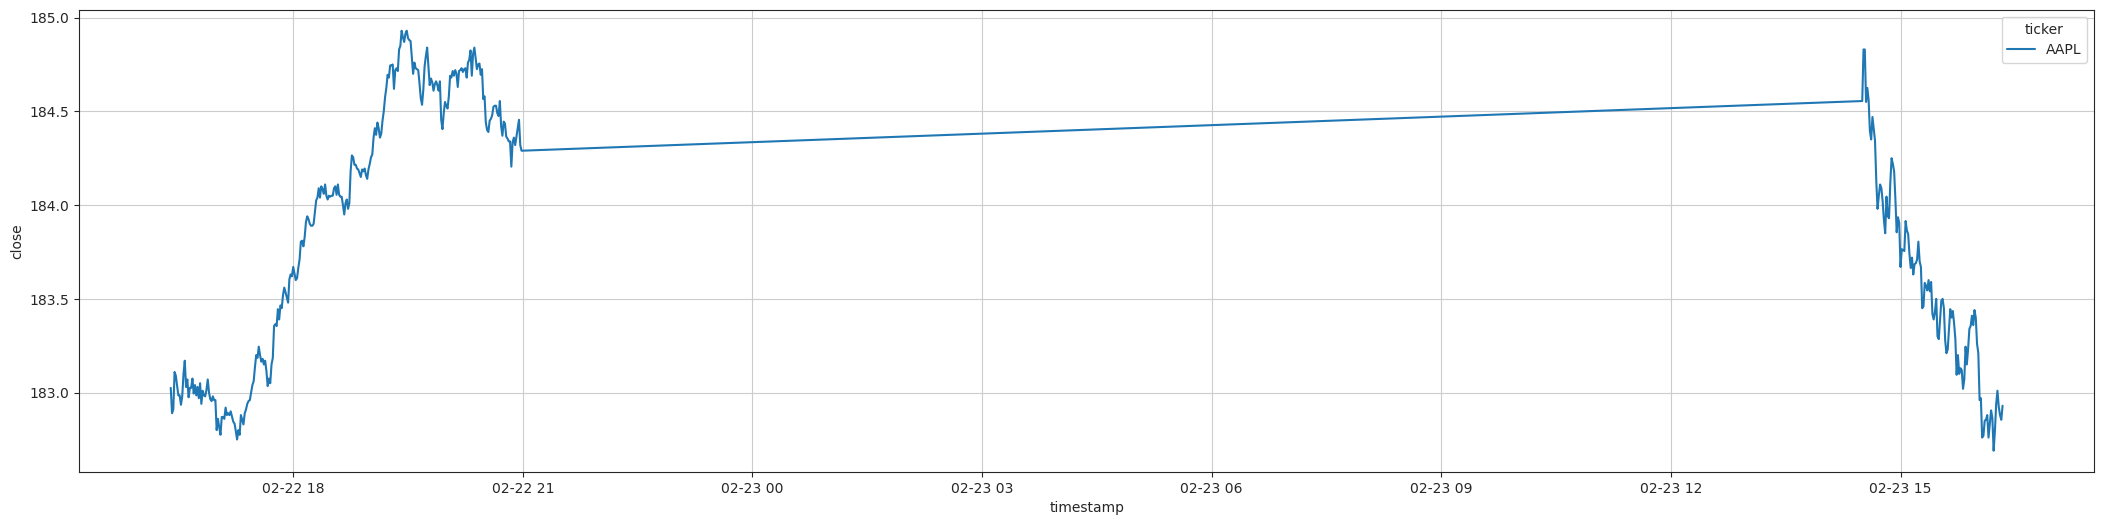

In [15]:
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(26,6))

sns.set_style("ticks",{'axes.grid' : True})

ax = sns.lineplot(df.toPandas(), x="timestamp", y="close", hue="ticker")
